# Sélection de variables : une introduction

Lino Galiana  
2025-03-19

<div class="badge-container"><div class="badge-text">Pour essayer les exemples présents dans ce tutoriel :</div><a href="https://github.com/linogaliana/python-datascientist-notebooks/blob/main/notebooks/modelisation/4_featureselection.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=github&label=&message=View%20on%20GitHub&color=181717" alt="View on GitHub"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/vscode-python?autoLaunch=true&name=«4_featureselection»&init.personalInit=«https%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmain%2Fsspcloud%2Finit-vscode.sh»&init.personalInitArgs=«modelisation%204_featureselection%20correction»" target="_blank" rel="noopener"><img src="https://custom-icon-badges.demolab.com/badge/SSP%20Cloud-Lancer_avec_VSCode-blue?logo=vsc&logoColor=white" alt="Onyxia"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&name=«4_featureselection»&init.personalInit=«https%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmain%2Fsspcloud%2Finit-jupyter.sh»&init.personalInitArgs=«modelisation%204_featureselection%20correction»" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSP%20Cloud-Lancer_avec_Jupyter-orange?logo=Jupyter&logoColor=orange" alt="Onyxia"></a>
<a href="https://colab.research.google.com/github/linogaliana/python-datascientist-notebooks-colab//blob/main//notebooks/modelisation/4_featureselection.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a><br></div>

Ce chapitre utilise toujours le même jeu de données, présenté dans l’[introduction
de cette partie](index.qmd) : les données de vote aux élections présidentielles américaines
croisées à des variables sociodémographiques.
Le code
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/main/content/modelisation/get_data.py).

In [1]:
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas

In [2]:
import pandas as pd

In [3]:
import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
votes = getdata.create_votes_dataframes()

Jusqu’à présent, nous avons supposé que les variables utiles à la prévision du
vote Républicain étaient connues du modélisateur. Nous n’avons ainsi exploité qu’une partie
limitée des variables disponibles dans nos données. Néanmoins, outre le fléau
computationnel que représenterait la construction d’un modèle avec un grand
nombre de variables, le choix d’un nombre restreint de variables
(modèle parcimonieux) limite le risque de sur-apprentissage.

Comment, dès lors, choisir le bon nombre de variables et la meilleure
combinaison de ces variables ? Il existe de multiples méthodes, parmi lesquelles :

-   se fonder sur des critères statistiques de performance qui pénalisent les
    modèles non parcimonieux. Par exemple, le BIC.
-   techniques de *backward elimination*.
-   construire des modèles pour lesquels la statistique d’intérêt pénalise l’absence
    de parcimonie (ce que l’on va souhaiter faire ici).

Dans ce chapitre, nous allons présenter
les enjeux principaux de la sélection
de variables par le biais du LASSO.

Nous allons utiliser par la suite les fonctions ou
packages suivants :

In [4]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import seaborn as sns

# 1. Principe du LASSO

## 1.1 Principe général

La classe des modèles de *feature selection* est ainsi très vaste et regroupe
un ensemble très divers de modèles. Nous allons nous focaliser sur le LASSO
(*Least Absolute Shrinkage and Selection Operator*)
qui est une extension de la régression linéaire qui vise à sélectionner des
modèles *sparses*. Ce type de modèle est central dans le champ du
*Compressed sensing* (où on emploie plutôt le terme
de *L1-regularization* que de LASSO). Le LASSO est un cas particulier des
régressions elastic-net dont un autre cas fameux est la régression *ridge*.
Contrairement à la régression linéaire classique, elles fonctionnent également
dans un cadre où $p>N$, c’est-à-dire où le nombre de régresseurs est très grand puisque supérieur
au nombre d’observations.

## 1.2 Pénalisation

En adoptant le principe d’une fonction objectif pénalisée,
le LASSO permet de fixer un certain nombre de coefficients à 0.
Les variables dont la norme est non nulle passent ainsi le test de sélection.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Tip</h3>

Le LASSO est un programme d’optimisation sous contrainte. On cherche à trouver l’estimateur $\beta$ qui minimise l’erreur quadratique (régression linéaire) sous une contrainte additionnelle régularisant les paramètres:
$$
\min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) \\ 
\text{s.t. } \sum_{j=1}^p |\beta_j| \leq t
$$

Ce programme se reformule grâce au Lagrangien et permet ainsi d’obtenir un programme de minimisation plus maniable :

$$
\beta^{\text{LASSO}} = \arg \min_{\beta} \frac{1}{2}\mathbb{E}\bigg( \big( X\beta - y  \big)^2 \bigg) + \alpha \sum_{j=1}^p |\beta_j| = \arg \min_{\beta} ||y-X\beta||_{2}^{2} + \lambda ||\beta||_1
$$

où $\lambda$ est une réécriture de la régularisation précédente qui dépend de $\alpha$. La force de la pénalité appliquée aux modèles non parcimonieux dépend de ce paramètre.

</div>

## 1.3 Première régression LASSO

Comme nous cherchons à trouver les
meilleurs prédicteurs du vote Républicain,
nous allons retirer les variables
qui sont dérivables directement de celles-ci : les scores des concurrents !

In [5]:
import pandas as pd

df2 = pd.DataFrame(votes.drop(columns='geometry'))
df2 = df2.loc[
  :,
  ~df2.columns.str.endswith(
    ('_democrat','_green','_other', 'winner', 'per_point_diff', 'per_dem')
    )
  ]


df2 = df2.loc[:,~df2.columns.duplicated()]

Dans cet exercice, nous utiliserons
également une fonction pour extraire
les variables sélectionnées par le LASSO,
la voici :

In [6]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

def extract_features_selected(lasso: Pipeline, preprocessing_step_name: str = 'preprocess') -> pd.Series:
    """
    Extracts selected features based on the coefficients obtained from Lasso regression.

    Parameters:
    - lasso (Pipeline): The scikit-learn pipeline containing a trained Lasso regression model.
    - preprocessing_step_name (str): The name of the preprocessing step in the pipeline. Default is 'preprocess'.

    Returns:
    - pd.Series: A Pandas Series containing selected features with non-zero coefficients.
    """
    # Check if lasso object is provided
    if not isinstance(lasso, Pipeline):
        raise ValueError("The provided lasso object is not a scikit-learn pipeline.")

    # Extract the final transformer from the pipeline
    lasso_model = lasso[-1]

    # Check if lasso_model is a Lasso regression model
    if not isinstance(lasso_model, Lasso):
        raise ValueError("The final step of the pipeline is not a Lasso regression model.")

    # Check if lasso model has 'coef_' attribute
    if not hasattr(lasso_model, 'coef_'):
        raise ValueError("The provided Lasso regression model does not have 'coef_' attribute. "
                         "Make sure it is a trained Lasso regression model.")

    # Get feature names from the preprocessing step
    features_preprocessing = lasso[preprocessing_step_name].get_feature_names_out()

    # Extract selected features based on non-zero coefficients
    features_selec = pd.Series(features_preprocessing[np.abs(lasso_model.coef_) > 0])

    return features_selec

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1 : Premier LASSO</h3>

On cherche toujours à prédire la variable `per_gop`. Avant de faire notre estimation, nous allons créer certains objets intermédiaires qui seront utilisés pour
définir notre *pipeline*:

1.  Dans notre `DataFrame`, remplacer les valeurs infinies par des `NaN`.

2.  Créez un échantillon d’entraînement et un échantillon test.

Maintenant nous pouvons passer au coeur de la définition de notre *pipeline*.
[Cet exemple](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) pourra servir de source
d’inspiration, ainsi que [celui-ci](https://www.kaggle.com/code/bextuychiev/lasso-regression-with-pipelines-tutorial).

1.  Créer en premier lieu les étapes
    de *preprocessing* pour notre modèle.
    Pour cela, il est d’usage de séparer les étapes appliquées aux variables numériques continues des autres variables, dites
    catégorielles.

-   Pour les **variables numériques**, imputer à la moyenne puis effectuer une standardisation ;
-   Pour les **variables catégorielles**, les techniques de régression linéaires impliquent d’utiliser une expansion par *one hot encoding*. Avant de faire ce *one hot encoding*, faire une imputation par valeur la plus fréquente.

1.  Finaliser le *pipeline* en ajoutant l’étape d’estimation puis estimer un modèle LASSO pénalisé avec $\alpha = 0.1$.

En supposant que votre *pipeline* soit dans un objet nommé `pipeline` et que la dernière étape
est nommée `model`, vous pouvez
directement accéder à cette étape en utilisant l’objet `pipeline['model']`.

1.  Afficher les valeurs des coefficients. Quelles variables ont une valeur non nulle ?
2.  Montrer que les variables sélectionnées sont parfois très corrélées.
3.  Comparer la performance de ce modèle parcimonieux avec celle d’un modèle avec plus de variables.

<details>

<summary>

Aide pour la question 1

</summary>

``` python
# Remplacer les infinis par des NaN
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
```

</details>

<details>

<summary>

Aide pour la question 3

</summary>

La définition d’un pipeline
suit la structure suivante :

``` python
numeric_pipeline = Pipeline(steps=[
    ('impute', # définir la méthode d'imputation ici
     ),
    ('scale', # définir la méthode de standardisation ici
    )
])

categorical_pipeline = # adapter le template

# À vous de définir en amont numerical_features et categorical_features
preprocessor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])
```

</details>

</div>

In [7]:
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
#2. Echantillon d'entraînement et échantillon test
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["per_gop"], axis = 1),
    100*df2[['per_gop']], test_size=0.2, random_state=0
)

In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer

numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()


numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


preprocessor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

Le *pipeline* de *preprocessing* (question 3) prend la forme suivante :

In [10]:
preprocessor

ColumnTransformer(transformers=[('number',
 Pipeline(steps=[('impute', SimpleImputer()),
 ('scale', StandardScaler())]),
 ['ALAND', 'AWATER', 'votes_gop', 'votes_dem',
 'total_votes', 'diff', 'FIPS_y',
 'Rural_Urban_Continuum_Code_2013',
 'Rural_Urban_Continuum_Code_2023',
 'Urban_Influence_2013',
 'Economic_typology_2015', 'CENSUS_2020_POP',
 'ESTIMATES_BASE_2020', 'POP_EST...
 'DEATHS_2020', 'DEATHS_2021', 'DEATHS_2022',
 'DEATHS_2023', 'NATURAL_CHG_2020', ...]),
 ('category',
 Pipeline(steps=[('impute',
 SimpleImputer(strategy='most_frequent')),
 ('one-hot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID',
 'GEOID', 'NAME', 'LSAD', 'FIPS_x',
 'state_name', 'county_fips', 'county_name',
 'State', 'Area_Name', 'FIPS'])]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. ColumnTransformer ? Documentation for ColumnTransformer i Not fitted ColumnTransformer(transformers=[('number',
 Pipeline(steps=[('impute', SimpleImputer()),
 ('scale', StandardScaler())]),
 ['ALAND', 'AWATER', 'votes_gop', 'votes_dem',
 'total_votes', 'diff', 'FIPS_y',
 'Rural_Urban_Continuum_Code_2013',
 'Rural_Urban_Continuum_Code_2023',
 'Urban_Influence_2013',
 'Economic_typology_2015', 'CENSUS_2020_POP',
 'ESTIMATES_BASE_2020', 'POP_EST...
 'DEATHS_2020', 'DEATHS_2021', 'DEATHS_2022',
 'DEATHS_2023', 'NATURAL_CHG_2020', ...]),
 ('category',
 Pipeline(steps=[('impute',
 SimpleImputer(strategy='most_frequent')),
 ('one-hot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID',
 'GEOID', 'NAME', 'LSAD', 'FIPS_x',
 'state_name', 'county_fips', 'county_name',
 'State', 'Area_Name', 'FIPS'])]) number ['ALAND', 'AWATER', 'votes_gop', 'votes_dem', 'total_votes', 'diff', 'FIPS_y', 'Rural_Urban_Continuum_Code_2013', 'Rural_Urban_Continuum_Code_2023', 'Urban_Influence_2013', 'Economic_typology_2015', 'CENSUS_2020_POP', 'ESTIMATES_BASE_2020', 'POP_ESTIMATE_2020', 'POP_ESTIMATE_2021', 'POP_ESTIMATE_2022', 'POP_ESTIMATE_2023', 'N_POP_CHG_2020', 'N_POP_CHG_2021', 'N_POP_CHG_2022', 'N_POP_CHG_2023', 'BIRTHS_2020', 'BIRTHS_2021', 'BIRTHS_2022', 'BIRTHS_2023', 'DEATHS_2020', 'DEATHS_2021', 'DEATHS_2022', 'DEATHS_2023', 'NATURAL_CHG_2020', 'NATURAL_CHG_2021', 'NATURAL_CHG_2022', 'NATURAL_CHG_2023', 'INTERNATIONAL_MIG_2020', 'INTERNATIONAL_MIG_2021', 'INTERNATIONAL_MIG_2022', 'INTERNATIONAL_MIG_2023', 'DOMESTIC_MIG_2020', 'DOMESTIC_MIG_2021', 'DOMESTIC_MIG_2022', 'DOMESTIC_MIG_2023', 'NET_MIG_2020', 'NET_MIG_2021', 'NET_MIG_2022', 'NET_MIG_2023', 'RESIDUAL_2020', 'RESIDUAL_2021', 'RESIDUAL_2022', 'RESIDUAL_2023', 'GQ_ESTIMATES_BASE_2020', 'GQ_ESTIMATES_2020', 'GQ_ESTIMATES_2021', 'GQ_ESTIMATES_2022', 'GQ_ESTIMATES_2023', 'R_BIRTH_2021', 'R_BIRTH_2022', 'R_BIRTH_2023', 'R_DEATH_2021', 'R_DEATH_2022', 'R_DEATH_2023', 'R_NATURAL_CHG_2021', 'R_NATURAL_CHG_2022', 'R_NATURAL_CHG_2023', 'R_INTERNATIONAL_MIG_2021', 'R_INTERNATIONAL_MIG_2022', 'R_INTERNATIONAL_MIG_2023', 'R_DOMESTIC_MIG_2021', 'R_DOMESTIC_MIG_2022', 'R_DOMESTIC_MIG_2023', 'R_NET_MIG_2021', 'R_NET_MIG_2022', 'R_NET_MIG_2023', '2003 Urban Influence Code', '2013 Urban Influence Code', '2013 Rural-urban Continuum Code', '2023 Rural-urban Continuum Code', 'Less than a high school diploma, 1970', 'High school diploma only, 1970', 'Some college (1-3 years), 1970', 'Four years of college or higher, 1970', 'Percent of adults with less than a high school diploma, 1970', 'Percent of adults with a high school diploma only, 1970', 'Percent of adults completing some college (1-3 years), 1970', 'Percent of adults completing four years of college or higher, 1970', 'Less than a high school diploma, 1980', 'High school diploma only, 1980', 'Some college (1-3 years), 1980', 'Four years of college or higher, 1980', 'Percent of adults with less than a high

In [11]:
# Question 4
model = Lasso(fit_intercept=True, alpha = 0.1)  

lasso_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', model)
])
lasso_pipeline.fit(X_train, y_train)

/opt/conda/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning:

Skipping features without any observed values: ['POV04_2021' 'CI90LB04_2021' 'CI90UB04_2021' 'PCTPOV04_2021'
 'CI90LB04P_2021' 'CI90UB04P_2021']. At least one non-missing value is needed for imputation with strategy='mean'.


Pipeline(steps=[('preprocess',
 ColumnTransformer(transformers=[('number',
 Pipeline(steps=[('impute',
 SimpleImputer()),
 ('scale',
 StandardScaler())]),
 ['ALAND', 'AWATER',
 'votes_gop', 'votes_dem',
 'total_votes', 'diff',
 'FIPS_y',
 'Rural_Urban_Continuum_Code_2013',
 'Rural_Urban_Continuum_Code_2023',
 'Urban_Influence_2013',
 'Economic_typology_2015',
 'CENSUS_2020_POP',...
 'NATURAL_CHG_2020', ...]),
 ('category',
 Pipeline(steps=[('impute',
 SimpleImputer(strategy='most_frequent')),
 ('one-hot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['STATEFP', 'COUNTYFP',
 'COUNTYNS', 'AFFGEOID',
 'GEOID', 'NAME', 'LSAD',
 'FIPS_x', 'state_name',
 'county_fips', 'county_name',
 'State', 'Area_Name',
 'FIPS'])])),
 ('model', Lasso(alpha=0.1))]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. Pipeline ? Documentation for Pipeline i Fitted Pipeline(steps=[('preprocess',
 ColumnTransformer(transformers=[('number',
 Pipeline(steps=[('impute',
 SimpleImputer()),
 ('scale',
 StandardScaler())]),
 ['ALAND', 'AWATER',
 'votes_gop', 'votes_dem',
 'total_votes', 'diff',
 'FIPS_y',
 'Rural_Urban_Continuum_Code_2013',
 'Rural_Urban_Continuum_Code_2023',
 'Urban_Influence_2013',
 'Economic_typology_2015',
 'CENSUS_2020_POP',...
 'NATURAL_CHG_2020', ...]),
 ('category',
 Pipeline(steps=[('impute',
 SimpleImputer(strategy='most_frequent')),
 ('one-hot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['STATEFP', 'COUNTYFP',
 'COUNTYNS', 'AFFGEOID',
 'GEOID', 'NAME', 'LSAD',
 'FIPS_x', 'state_name',
 'county_fips', 'county_name',
 'State', 'Area_Name',
 'FIPS'])])),
 ('model', Lasso(alpha=0.1))]) preprocess: ColumnTransformer ? Documentation for preprocess: ColumnTransformer ColumnTransformer(transformers=[('number',
 Pipeline(steps=[('impute', SimpleImputer()),
 ('scale', StandardScaler())]),
 ['ALAND', 'AWATER', 'votes_gop', 'votes_dem',
 'total_votes', 'diff', 'FIPS_y',
 'Rural_Urban_Continuum_Code_2013',
 'Rural_Urban_Continuum_Code_2023',
 'Urban_Influence_2013',
 'Economic_typology_2015', 'CENSUS_2020_POP',
 'ESTIMATES_BASE_2020', 'POP_EST...
 'DEATHS_2020', 'DEATHS_2021', 'DEATHS_2022',
 'DEATHS_2023', 'NATURAL_CHG_2020', ...]),
 ('category',
 Pipeline(steps=[('impute',
 SimpleImputer(strategy='most_frequent')),
 ('one-hot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID',
 'GEOID', 'NAME', 'LSAD', 'FIPS_x',
 'state_name', 'county_fips', 'county_name',
 'State', 'Area_Name', 'FIPS'])]) number ['ALAND', 'AWATER', 'votes_gop', 'votes_dem', 'total_votes', 'diff', 'FIPS_y', 'Rural_Urban_Continuum_Code_2013', 'Rural_Urban_Continuum_Code_2023', 'Urban_Influence_2013', 'Economic_typology_2015', 'CENSUS_2020_POP', 'ESTIMATES_BASE_2020', 'POP_ESTIMATE_2020', 'POP_ESTIMATE_2021', 'POP_ESTIMATE_2022', 'POP_ESTIMATE_2023', 'N_POP_CHG_2020', 'N_POP_CHG_2021', 'N_POP_CHG_2022', 'N_POP_CHG_2023', 'BIRTHS_2020', 'BIRTHS_2021', 'BIRTHS_2022', 'BIRTHS_2023', 'DEATHS_2020', 'DEATHS_2021', 'DEATHS_2022', 'DEATHS_2023', 'NATURAL_CHG_2020', 'NATURAL_CHG_2021', 'NATURAL_CHG_2022', 'NATURAL_CHG_2023', 'INTERNATIONAL_MIG_2020', 'INTERNATIONAL_MIG_2021', 'INTERNATIONAL_MIG_2022', 'INTERNATIONAL_MIG_2023', 'DOMESTIC_MIG_2020', 'DOMESTIC_MIG_2021', 'DOMESTIC_MIG_2022', 'DOMESTIC_MIG_2023', 'NET_MIG_2020', 'NET_MIG_2021', 'NET_MIG_2022', 'NET_MIG_2023', 'RESIDUAL_2020', 'RESIDUAL_2021', 'RESIDUAL_2022', 'RESIDUAL_2023', 'GQ_ESTIMATES_BASE_2020', 'GQ_ESTIMATES_2020', 'GQ_ESTIMATES_2021', 'GQ_ESTIMATES_2022', 'GQ_ESTIMATES_2023', 'R_BIRTH_2021', 'R_BIRTH_2022', 'R_BIRTH_2023', 'R_DEATH_2021', 'R_DEATH_2022', 'R_DEATH_2023', 'R_NATURAL_CHG_2021', 'R_NATURAL_CHG_2022', 'R_NATURAL_CHG_2023', 'R_INTERNATIONAL_MIG_2021', 'R_INTERNATIONAL_MIG_2022', 'R_INTERNATIONAL_MIG_2023', 'R_DOMESTIC_MIG_2021', 'R_DOMESTI

Le *pipeline* prend la forme suivante, une fois finalisé (question 4) :

In [12]:
lasso_pipeline

Pipeline(steps=[('preprocess',
 ColumnTransformer(transformers=[('number',
 Pipeline(steps=[('impute',
 SimpleImputer()),
 ('scale',
 StandardScaler())]),
 ['ALAND', 'AWATER',
 'votes_gop', 'votes_dem',
 'total_votes', 'diff',
 'FIPS_y',
 'Rural_Urban_Continuum_Code_2013',
 'Rural_Urban_Continuum_Code_2023',
 'Urban_Influence_2013',
 'Economic_typology_2015',
 'CENSUS_2020_POP',...
 'NATURAL_CHG_2020', ...]),
 ('category',
 Pipeline(steps=[('impute',
 SimpleImputer(strategy='most_frequent')),
 ('one-hot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['STATEFP', 'COUNTYFP',
 'COUNTYNS', 'AFFGEOID',
 'GEOID', 'NAME', 'LSAD',
 'FIPS_x', 'state_name',
 'county_fips', 'county_name',
 'State', 'Area_Name',
 'FIPS'])])),
 ('model', Lasso(alpha=0.1))]) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. Pipeline ? Documentation for Pipeline i Fitted Pipeline(steps=[('preprocess',
 ColumnTransformer(transformers=[('number',
 Pipeline(steps=[('impute',
 SimpleImputer()),
 ('scale',
 StandardScaler())]),
 ['ALAND', 'AWATER',
 'votes_gop', 'votes_dem',
 'total_votes', 'diff',
 'FIPS_y',
 'Rural_Urban_Continuum_Code_2013',
 'Rural_Urban_Continuum_Code_2023',
 'Urban_Influence_2013',
 'Economic_typology_2015',
 'CENSUS_2020_POP',...
 'NATURAL_CHG_2020', ...]),
 ('category',
 Pipeline(steps=[('impute',
 SimpleImputer(strategy='most_frequent')),
 ('one-hot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['STATEFP', 'COUNTYFP',
 'COUNTYNS', 'AFFGEOID',
 'GEOID', 'NAME', 'LSAD',
 'FIPS_x', 'state_name',
 'county_fips', 'county_name',
 'State', 'Area_Name',
 'FIPS'])])),
 ('model', Lasso(alpha=0.1))]) preprocess: ColumnTransformer ? Documentation for preprocess: ColumnTransformer ColumnTransformer(transformers=[('number',
 Pipeline(steps=[('impute', SimpleImputer()),
 ('scale', StandardScaler())]),
 ['ALAND', 'AWATER', 'votes_gop', 'votes_dem',
 'total_votes', 'diff', 'FIPS_y',
 'Rural_Urban_Continuum_Code_2013',
 'Rural_Urban_Continuum_Code_2023',
 'Urban_Influence_2013',
 'Economic_typology_2015', 'CENSUS_2020_POP',
 'ESTIMATES_BASE_2020', 'POP_EST...
 'DEATHS_2020', 'DEATHS_2021', 'DEATHS_2022',
 'DEATHS_2023', 'NATURAL_CHG_2020', ...]),
 ('category',
 Pipeline(steps=[('impute',
 SimpleImputer(strategy='most_frequent')),
 ('one-hot',
 OneHotEncoder(handle_unknown='ignore',
 sparse_output=False))]),
 ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID',
 'GEOID', 'NAME', 'LSAD', 'FIPS_x',
 'state_name', 'county_fips', 'county_name',
 'State', 'Area_Name', 'FIPS'])]) number ['ALAND', 'AWATER', 'votes_gop', 'votes_dem', 'total_votes', 'diff', 'FIPS_y', 'Rural_Urban_Continuum_Code_2013', 'Rural_Urban_Continuum_Code_2023', 'Urban_Influence_2013', 'Economic_typology_2015', 'CENSUS_2020_POP', 'ESTIMATES_BASE_2020', 'POP_ESTIMATE_2020', 'POP_ESTIMATE_2021', 'POP_ESTIMATE_2022', 'POP_ESTIMATE_2023', 'N_POP_CHG_2020', 'N_POP_CHG_2021', 'N_POP_CHG_2022', 'N_POP_CHG_2023', 'BIRTHS_2020', 'BIRTHS_2021', 'BIRTHS_2022', 'BIRTHS_2023', 'DEATHS_2020', 'DEATHS_2021', 'DEATHS_2022', 'DEATHS_2023', 'NATURAL_CHG_2020', 'NATURAL_CHG_2021', 'NATURAL_CHG_2022', 'NATURAL_CHG_2023', 'INTERNATIONAL_MIG_2020', 'INTERNATIONAL_MIG_2021', 'INTERNATIONAL_MIG_2022', 'INTERNATIONAL_MIG_2023', 'DOMESTIC_MIG_2020', 'DOMESTIC_MIG_2021', 'DOMESTIC_MIG_2022', 'DOMESTIC_MIG_2023', 'NET_MIG_2020', 'NET_MIG_2021', 'NET_MIG_2022', 'NET_MIG_2023', 'RESIDUAL_2020', 'RESIDUAL_2021', 'RESIDUAL_2022', 'RESIDUAL_2023', 'GQ_ESTIMATES_BASE_2020', 'GQ_ESTIMATES_2020', 'GQ_ESTIMATES_2021', 'GQ_ESTIMATES_2022', 'GQ_ESTIMATES_2023', 'R_BIRTH_2021', 'R_BIRTH_2022', 'R_BIRTH_2023', 'R_DEATH_2021', 'R_DEATH_2022', 'R_DEATH_2023', 'R_NATURAL_CHG_2021', 'R_NATURAL_CHG_2022', 'R_NATURAL_CHG_2023', 'R_INTERNATIONAL_MIG_2021', 'R_INTERNATIONAL_MIG_2022', 'R_INTERNATIONAL_MIG_2023', 'R_DOMESTIC_MIG_2021', 'R_DOMESTI

À l’issue de la question 5, les variables sélectionnées sont :

In [13]:
# Question 5
lasso1 = lasso_pipeline['model']
features_selec = extract_features_selected(lasso_pipeline)
#np.abs(lasso1.coef_)

Le modèle est assez parcimonieux puisqu’un sous-échantillon de nos
variables initiales (d’autant que nos variables catégorielles
ont été éclatées en de nombreuses variables
par le *one hot encoding*).

In [14]:
features_selec.str.replace("(number__|category__)", "", regex = True)

0                                                 ALAND
1                                                FIPS_y
2                       Rural_Urban_Continuum_Code_2023
3                                        N_POP_CHG_2020
4                                INTERNATIONAL_MIG_2023
5                                     DOMESTIC_MIG_2023
6                                         RESIDUAL_2020
7                                         RESIDUAL_2021
8                       2023 Rural-urban Continuum Code
9     Percent of adults with a bachelor's degree or ...
10    Percent of adults with a high school diploma o...
11    Percent of adults with a bachelor's degree or ...
12    Percent of adults with less than a high school...
13    Percent of adults with a bachelor's degree or ...
14                                           Metro_2013
15                               Unemployment_rate_2000
16                               Unemployment_rate_2002
17                               Unemployment_ra

Certaines variables font sens, comme les variables d’éducation par exemple. Notamment, un des meilleurs prédicteurs pour le score des Républicains en 2020 est… le score des Républicains (et mécaniquement des démocrates) en 2016 et 2012.

Par ailleurs, on sélectionne des variables redondantes. Une phase plus approfondie de nettoyage des données serait en réalité nécessaire.

In [15]:
#4. Corrélations entre les variables sélectionnées

features_selected = features_selec.loc[features_selec.str.startswith("number__")].str.replace("number__", "", regex = True)

corr = df2.loc[: , features_selected].corr()

plt.figure()
p = corr.style.background_gradient(cmap='coolwarm', axis=None).format('{:.2f}')
p

In [16]:
from sklearn.metrics import root_mean_squared_error, r2_score

def print_regression_metrics(y_true, y_pred, model_name=""):
    """
    Print RMSE and R^2 for regression analysis.

    Parameters:
    - y_true (array-like): The true target values.
    - y_pred (array-like): The predicted target values.
    - model_name (str): Name of the regression model. Default is an empty string.
    """
    rmse = root_mean_squared_error(y_true, y_pred)
    rsq = r2_score(y_true, y_pred)

    print(f"{model_name} Regression:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2: {rsq:.4f}")
    
    return rmse, rsq


# 5. Faire une régression linéaire parcimonieuse et non parcimonieuse

# Régression parcimonieuse
lasso_pipeline = Pipeline(steps=[
    ('preprocess', ColumnTransformer(transformers=[
        ('number', numeric_pipeline, numerical_features)
    ])),
    ('model', Lasso())
])

lasso_pipeline.fit(X_train, y_train)

y_pred_parci = lasso_pipeline.predict(X_test)
rmse_parci, rsq_parci = print_regression_metrics(
  y_test, y_pred_parci,
  "Régression parcimonieuse"
) 


# Régression non parcimonieuse
ols_pipeline = Pipeline(steps=[
    ('preprocess', ColumnTransformer(transformers=[
        ('number', numeric_pipeline, numerical_features)
    ])),
    ('scaler', StandardScaler()),  # Add scaling for LinearRegression
    ('model', LinearRegression())
])

ols_pipeline.fit(X_train, y_train)

y_pred_nonparci = ols_pipeline.predict(X_test)

rmse_nonparci, rsq_nonparci = print_regression_metrics(
  y_test, y_pred_nonparci,
  "Régression non parcimonieuse"
) 

Le modèle parcimonieux est (légèrement) plus performant :

In [17]:
pd.DataFrame({
  "parcimonieux": [rmse_parci, rsq_parci, len(features_selected)],
  "non parcimonieux": [rmse_nonparci, rsq_nonparci, ols_pipeline[-1].coef_.shape[1] + 1]},
  index = ['RMSE', 'R2', 'Nombre de paramètres']
)

D’ailleurs, on pourrait déjà remarquer
que régresser le score de 2020 sur celui
de 2016 amène déjà à de très bonnes
performances explicatives, ce qui suggère
que le vote se comporte comme un processus
autorégressif :

In [18]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
smf.ols("per_gop ~ share_2016_republican", data = df2).fit().summary()

Notes: [1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

# 2. Rôle de la pénalisation $\alpha$ sur la sélection de variables

Nous avons jusqu’à présent pris l’hyperparamètre $\alpha$
comme donné. Quel rôle joue-t-il dans les conclusions de
notre modélisation ? Pour cela, nous pouvons
explorer l’effet que sa valeur peut avoir sur le nombre
de variables passant l’étape de sélection.

Pour le prochain
exercice, nous allons considérer exclusivement
les variables quantitatives pour accélérer les calculs.
En effet, avec des modèles non parcimonieux, les multiples
modalités de nos variables catégorielles rendent le problème
d’optimisation difficilement tractable.

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

df2.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(["per_gop"], axis = 1),
    100*df2[['per_gop']], test_size=0.2, random_state=0
)

numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])
preprocessed_features = pd.DataFrame(
  numeric_pipeline.fit_transform(
    X_train.drop(columns = categorical_features)
  )
)

/opt/conda/lib/python3.12/site-packages/sklearn/impute/_base.py:635: UserWarning:

Skipping features without any observed values: ['POV04_2021' 'CI90LB04_2021' 'CI90UB04_2021' 'PCTPOV04_2021'
 'CI90LB04P_2021' 'CI90UB04P_2021']. At least one non-missing value is needed for imputation with strategy='mean'.


<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 2 : Rôle du paramètre de pénalisation</h3>

Utiliser la fonction `lasso_path` pour évaluer le nombre de paramètres sélectionnés par LASSO lorsque $\alpha$
varie (parcourir $\alpha \in [0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0]$).

</div>

In [20]:
#6. Utilisation de lasso_path
my_alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])

alpha_for_path, coefs_lasso, _ = lasso_path(
  preprocessed_features,
  y_train,
  alphas=my_alphas)
#print(coefs_lasso)
nb_non_zero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)
nb_non_zero = pd.DataFrame(
  nb_non_zero
).sum(axis = 0)

# graphique

sns.set_style("whitegrid")
plt.figure()
p = sns.lineplot(y=nb_non_zero, x=alpha_for_path)
p.set(title = r"Number variables and regularization parameter ($\alpha$)", xlabel=r'$\alpha$', ylabel='Nb. de variables')

La relation que vous devriez obtenir entre $\alpha$ et
le nombre de paramètres est celle-ci :

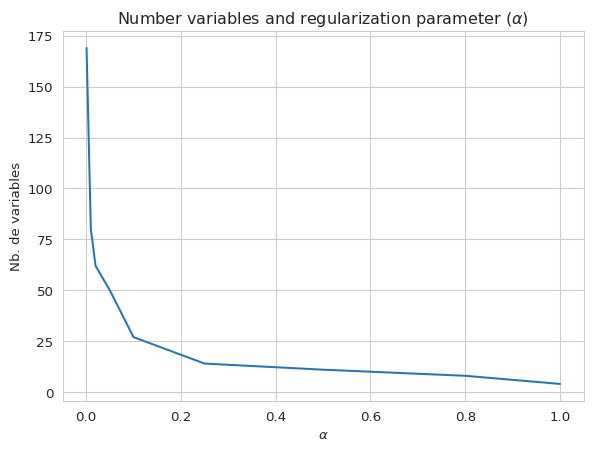

In [21]:
p.figure.get_figure()

On voit que plus $\alpha$ est élevé, moins le modèle sélectionne de variables.

In [22]:
p.figure.get_figure().savefig("featured_selection.png")

# 3. Validation croisée pour sélectionner le modèle

Quel $\alpha$ faut-il privilégier ? Pour cela,
il convient d’effectuer une validation croisée afin de choisir le modèle pour
lequel les variables qui passent la phase de sélection permettent de mieux
prédire le résultat Républicain.

In [23]:
from sklearn.linear_model import LassoCV

my_alphas = np.array([0.001,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])

lcv = (
  LassoCV(
    alphas=my_alphas,
    fit_intercept=False,
    random_state=0,
    cv=5
    ).fit(
      preprocessed_features, y_train
    )
)

On peut récupérer le *“meilleur”* $\alpha$ :

In [24]:
print("alpha optimal :", lcv.alpha_)

alpha optimal : 1.0

Celui-ci peut être utilisé pour faire tourner un nouveau *pipeline* :

In [25]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

model = Lasso(
  fit_intercept=False, 
  alpha = lcv.alpha_
)  

lasso_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', model)
])

lasso_optimal = lasso_pipeline.fit(X_train,y_train)

features_selec2 = extract_features_selected(lasso_optimal)

Les variables sélectionnées sont :

In [26]:
features_selec2.str.replace("(number__|category__)", "", regex = True)

0                                          R_BIRTH_2021
1                                          R_DEATH_2023
2     Percent of adults completing some college or a...
3     Percent of adults with a bachelor's degree or ...
4     Percent of adults with a bachelor's degree or ...
5     Percent of adults with a high school diploma o...
6                                        CI90LBINC_2021
7                        candidatevotes_2016_republican
8                                 share_2008_republican
9                                 share_2012_republican
10                                share_2016_republican
11                                           STATEFP_22
12                                              LSAD_06
dtype: object

Cela correspond à un modèle avec 13 variables sélectionnées.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Tip</h3>

Dans le cas où le modèle paraîtrait trop peu parcimonieux, il faudrait revoir la phase de définition des variables pertinentes pour comprendre si des échelles différentes de certaines variables ne seraient pas plus appropriées (par exemple du `log`).

</div>